## Non-Relativistic Particle-in-cell simulator [NRPIC_UPV]
##### Marco Nieto

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from mpl_toolkits import mplot3d
import random as rd
import scipy.linalg as la
import os
import shutil
import imageio

#### Beam specifications (meters)
- Charge (q) $[\pm 1,0]$
- Particles (N)
- Energy of each particle (eV)
- Particle mass

We assume that the particle is non-relativistic, therefore its initial velocity is defined, given by the expression:

$$ |\vec{\textbf{v}}| = \sqrt{\frac{2 e} {m}} \pm k$$

Being $k$ a perturbation, sum of the three deviations of each velocity component $v_i$ from the central value with a $\kappa$% factor.

An additional restriction for a maximum dispersion angle $\alpha$ has to be taken in account. The model generates for each particle two initial values of $\phi$ and $\theta$ such that $\phi \in [-\frac{\alpha}{2}, \frac{\alpha}{2}]$ and $\theta \in [\frac{\pi}{2}-\frac{\alpha}{2}, \frac{\pi}{2}+\frac{\alpha}{2}]$. Velocity components can be obtained as:

$$ v_x= |\vec{\textbf{v}}| \sin(\theta)\cos(\phi) $$
$$ v_y= |\vec{\textbf{v}}| \sin(\theta)\sin(\phi)$$
$$ v_z= |\vec{\textbf{v}}| \cos(\theta) $$

In [17]:
def linear_scattering(x,y,z,m,n,o,a,b,L,N):
	hx = L/m 
	hy = a/n
	hz = b/o
	mesh = np.zeros((m+1,n+1,o+1))

	for i in range(N):
		xgreater = False
		ygreater = False
		zgreater = False
		xsteps = 0
		ysteps = 0
		zsteps = 0
		while xgreater == False:
			if x[i]<hx*xsteps:
				xgreater = True
			else:
				xsteps += 1
		while ygreater == False:
			if y[i]<hy*ysteps:
				ygreater = True	
			else:
				ysteps += 1
		while zgreater == False:
			if z[i]<hz*zsteps:
				zgreater = True	
			else:
				zsteps += 1
		
	
		weight_nextx = (1-(hx*xsteps-x[i])/hx)
		weight_prevx = 1-weight_nextx
		weight_nexty = (1-(hy*ysteps-y[i])/hy)
		weight_prevy = 1-weight_nexty
		weight_nextz = (1-(hz*zsteps-z[i])/hz)
		weight_prevz = 1-weight_nextz

		mesh[xsteps-1][ysteps-1][zsteps-1] += weight_prevx*weight_prevy*weight_prevz
		mesh[xsteps-1][ysteps-1][zsteps] += weight_prevx*weight_prevy*weight_nextz
		mesh[xsteps-1][ysteps][zsteps-1] += weight_prevx*weight_nexty*weight_prevz
		mesh[xsteps-1][ysteps][zsteps] += weight_prevx*weight_nexty*weight_nextz
		mesh[xsteps][ysteps-1][zsteps-1] += weight_nextx*weight_prevy*weight_prevz
		mesh[xsteps][ysteps-1][zsteps] += weight_nextx*weight_prevy*weight_nextz
		mesh[xsteps][ysteps][zsteps-1] += weight_nextx*weight_nexty*weight_prevz
		mesh[xsteps][ysteps][zsteps] += weight_nextx*weight_nexty*weight_nextz
		
	return mesh




def solve_field(mesh, m,n,o,a,b,L):
	hx = L/m 
	hy = a/n
	hz = b/o

	#Electric field approximation---------(poisson equation and gradient of the obtained potential)----------------------
	#Poisson equation for electric potential--------------------------------------------
	coeff_matrix = np.zeros(((m+1)*(n+1)*(o+1), (m+1)*(n+1)*(o+1)))
	for i in range((m+1)*(n+1)*(o+1)):
		coeff_matrix[i][i] = -(2/hx**2 + 2/hy**2 + 2/hz**2)
		if ((n+1)-i%(n+1)!=1): 
			coeff_matrix[i][i+1] = 1/hy**2 #y + hy
		if (i%(n+1)!=0):
			coeff_matrix[i][i-1] = 1/hy**2 #y - hy

		if ((o+1)-(i//(n+1)%(o+1)) != 1 ): 
			coeff_matrix[i][i+(n+1)] = -(2/hx**2 + 2/hy**2 + 2/hz**2) #z + hz
		if ((i//(n+1)%(o+1)) != 0 ):
			coeff_matrix[i][i-(n+1)] = -(2/hx**2 + 2/hy**2 + 2/hz**2) #z - hz

		if ((m+1)-(i//((n+1)*(o+1))) != 1): 
			coeff_matrix[i][i+((n+1)*(o+1))] = -(2/hx**2 + 2/hy**2 + 2/hz**2) #x + hx
		if (i//((n+1)*(o+1)) > 0): 
			coeff_matrix[i][i-((n+1)*(o+1))] = -(2/hx**2 + 2/hy**2 + 2/hz**2) #x - hx
			
	vect_indep = np.zeros((m+1)*(n+1)*(o+1))
	
	for i in range(len(vect_indep)):
		vect_indep[i] = mesh[i//((n+1)*(o+1))][(i//(n+1)%(o+1))][((i%(n+1)))]/(8.854187817*10**(-12))

	field_nodes_vector = la.solve(coeff_matrix, vect_indep)
	field_nodes = np.zeros((m+1,n+1,o+1))
	pos = 0
	for i in range(m+1):
		for j in range(o+1):
			for k in range(n+1):
				field_nodes[i][j][k] = field_nodes_vector[pos]
				pos +=1
	#Electric field from potential gradient----------------------------------------------------
	'''
	Ex_nodes_vector = np.zeros((m+1)*(n+1)*(o+1))
	for i in range((m+1)*(n+1)*(o+1)):
		if (i//((m+1)*(n+1)*(o+1))==0): 
			Ex_nodes_vector[i] = (field_nodes_vector[i+((m+1)*(n+1)*(o+1))]-field_nodes_vector[i])/(hx) #forward difference
		elif (i//((m+1)*(n+1)*(o+1))==m):
			Ex_nodes_vector[i] = (field_nodes_vector[i]-field_nodes_vector[i-((m+1)*(n+1)*(o+1))])/(hx) #backward difference
		else:
			Ex_nodes_vector[i] = (field_nodes_vector[i+((m+1)*(n+1)*(o+1))]-field_nodes_vector[i-((m+1)*(n+1)*(o+1))])/(2*hx) #centered difference

	Ey_nodes_vector = np.zeros((m+1)*(n+1)*(o+1))
	for i in range((m+1)*(n+1)*(o+1)):
		if (i%(n+1)==0): 
			Ey_nodes_vector[i] = (field_nodes_vector[i+1]-field_nodes_vector[i])/(hy) #forward difference
		elif (i%(n+1)==n):
			Ey_nodes_vector[i] = (field_nodes_vector[i]-field_nodes_vector[i-1])/(hy) #backward difference
		else:
			Ey_nodes_vector[i] = (field_nodes_vector[i+1]-field_nodes_vector[i-1])/(2*hy) #centered difference
	Ez_nodes_vector = np.zeros((m+1)*(n+1)*(o+1))
	for i in range((m+1)*(n+1)*(o+1)):
		if (i//(o+1)%(o+1)==0): 
			Ez_nodes_vector[i] = (field_nodes_vector[i+(n+1)]-field_nodes_vector[i])/(hz) #forward difference
		elif (i//(o+1)%(o+1)==o):
			Ez_nodes_vector[i] = (field_nodes_vector[i]-field_nodes_vector[i-(n+1)])/(hz) #backward difference
		else:
			Ez_nodes_vector[i] = (field_nodes_vector[i+(n+1)]-field_nodes_vector[i-(n+1)])/(2*hz) #centered difference

	return [Ex_nodes_vector, Ey_nodes_vector, Ez_nodes_vector]
	'''




def push_particles(deltat, x, y, z, vx, vy, vz, step):
    for particle in range(len(x[0])):
        x[step+1][particle] = x[step][particle] + vx[step][particle]*deltat
        vx[step+1][particle] = vx[step][particle]
    for particle in range(len(y[0])):
        y[step+1][particle] = y[step][particle] + vy[step][particle]*deltat
        vy[step+1][particle] = vy[step][particle]
    for particle in range(len(z[0])):
        z[step+1][particle] = z[step][particle] + vz[step][particle]*deltat
        vz[step+1][particle] = vz[step][particle]

def draw_trajectories(x,y,z,ax):
	base_tone = (0.5, 0, 0)  # RGB values for red (dark red) within 0-1 range
	rand_colors = np.random.rand(len(x.T), 3) * 0.5 # Adjust the range for lighter or darker colors within 0-1 range
	colors = base_tone + rand_colors
	for i in range(len(colors)):
			colors[i][1] = 0
			colors[i][2] = 0
	for i in range(len(x.T)):
         ax.plot(x.T[i], y.T[i], z.T[i], c=colors[i], marker='o', markersize=1)


def pic(m,n,o,a,b,L,N, alpha, kappa, E, mass, tsteps, deltat, image_parameters):

	path = os.path.join(os.getcwd(), "New_simulation")
	shutil.rmtree(path)
	os.makedirs(path, exist_ok=True)
	data_path = os.path.join(path, "data")
	os.makedirs(data_path, exist_ok=True)
	print("Directory for the simulation data created")	

	#initial conditions-----------------------------------------------------------------------------------------------------
	x = np.zeros((N, tsteps)).T
	y = np.zeros((N, tsteps)).T
	z = np.zeros((N, tsteps)).T
	y[0] = np.random.uniform(a/2 - c/2, a/2 +c/2, N)
	z[0] = np.random.uniform(b/2 - d/2, b/2 +d/2, N)
	
	vx = np.zeros((N, tsteps)).T
	vy = np.zeros((N, tsteps)).T
	vz = np.zeros((N, tsteps)).T

	modv = np.sqrt(2*E/m)
	for i in range(N):
		theta = np.random.uniform(np.pi/2 - alpha/2 ,np.pi/2 + alpha/2, 1)[0]
		phi = np.random.uniform(-alpha/2 ,alpha/2, 1)[0]
		vx[0][i]= modv * np.cos(phi)*np.sin(theta) + ((rd.random()*2)-1)*(modv * np.cos(phi)*np.sin(theta))*(kappa/100)
		vy[0][i]= modv * np.sin(phi)*np.sin(theta) + ((rd.random()*2)-1)*(modv * np.sin(phi)*np.sin(theta))*(kappa/100)
		vz[0][i]= modv * np.cos(theta) + ((rd.random()*2)-1)*(modv * np.cos(theta))*(kappa/100)
	#----------------------------------------------------------------------------------------------------------------------
	print("Inital conditions applyed succesfully")

	#Prepares program to save images if desired----------------------------------------------------------------------------
	save_meshes = False
	save_Efield = False
	meshes_cum = list(np.zeros(tsteps))
	Efield_cum = list(np.zeros(tsteps))
	if (image_parameters[0]!=(-1) or image_parameters[1]!=(-1) or image_parameters[2]!=(-1)):
		save_meshes = True
		results_path = os.path.join(path, "results")
		os.makedirs(results_path, exist_ok=True)
	if (image_parameters[3]!=(-1) or image_parameters[4]!=(-1) or image_parameters[5]!=(-1)):
		save_Efield = True
		results_path = os.path.join(path, "results")
		os.makedirs(results_path, exist_ok=True)
	#----------------------------------------------------------------------------------------------------------------------

	#Apply PIC steps-------------------------------------------------------------------------------------------------------
	for step in range(tsteps-1):
		mesh = linear_scattering(x[step],y[step],z[step],m,n,o,a,b,L,N)
		if save_meshes:
			meshes_cum[step] = mesh
		#axs.imshow(mesh[0], interpolation='bilinear', cmap='viridis')

		field_nodes = solve_field(mesh, m,n,o,a,b,L)
		#print(field_nodes)
		#axs[0].imshow(field_nodes[0], interpolation='bilinear', cmap='viridis')

		#calculate_acceleration(mesh, x,y,z,vx,vy,vz,m,n,o,a,b,L, step):
		push_particles(deltat, x, y, z, vx, vy, vz, step)
		print(f"computed step {step}/{tsteps}")

	#----------------------------------------------------------------------------------------------------------------------

	#Generates images and 3D trajectories representations-------------------------------------------------------------------
	generate_images(data_path, results_path, tsteps, meshes_cum, Efield_cum, m, n, o)

	'''
	if (image_parameters[6]==1):
		model_path = os.path.join(data_path, "represent_3d")
		os.makedirs(model_path, exist_ok=True)
		frames = []
		base_tone = (0.5, 0, 0)  # RGB values for red (dark red) within 0-1 range
		rand_colors = np.random.rand(len(x.T), 3) * 0.5 # Adjust the range for lighter or darker colors within 0-1 range
		colors = base_tone + rand_colors
		for i in range(len(colors)):
			colors[i][1] = 0
			colors[i][2] = 0
		for i in range (tsteps-1):	
			for j in range(len(x.T)):
				fig = plt.figure(figsize=(20, 14))
				ax = fig.add_subplot(111, projection='3d')
				generate_enclosure(a,b,c,d,L,ax)
				ax.plot(x.T[j][:i+1], y.T[j][:i+1], z.T[j][:i+1], c=colors[j], marker='o', markersize=1)
			plt.savefig(f'{model_path}/img_{i}.png', transparent = False,  facecolor = 'white')
			plt.close()
			image = imageio.imread(f'{model_path}/img_{i}.png')
			frames.append(image)
		imageio.mimsave(f'{results_path}/3d_model.gif',frames, format='GIF', fps=8)
	'''

	if (image_parameters[6]==1):
		model_path = os.path.join(data_path, "represent_3d")
		os.makedirs(model_path, exist_ok=True)
		frames = []
		for i in range (tsteps-1):	
			fig = plt.figure(figsize=(20, 14))
			ax = fig.add_subplot(111, projection='3d')
			generate_enclosure(a,b,c,d,L, ax)
			draw_trajectories(x[:i+1],y[:i+1],z[:i+1],ax)
			plt.savefig(f'{model_path}/img_{i}.png', transparent = False,  facecolor = 'white')
			plt.close()
			image = imageio.imread(f'{model_path}/img_{i}.png')
			frames.append(image)
		imageio.mimsave(f'{results_path}/3d_model.gif',frames, format='GIF', fps=8)
		print(f"3D Model GIF rendered")

	if (image_parameters[6]==2):
		fig = plt.figure(figsize=(20, 14))
		ax = fig.add_subplot(111, projection='3d')
		generate_enclosure(a,b,c,d,L, ax)
		draw_trajectories(x,y,z,ax)
		plt.savefig(f'{results_path}/img_MODEL_3D.png', transparent = False,  facecolor = 'white')
		plt.close()
		print(f"3D Model image rendered")

	print(f"Simulation finished")
			



def generate_images(data_path, results_path, tsteps, meshes_cum, Efield_cum, m, n, o):
	if (image_parameters[0]!=(-1)):
		transv_sec_x = os.path.join(data_path, "transv_sec_x")
		os.makedirs(transv_sec_x, exist_ok=True)
		frames = []
		for step in range(tsteps-1):
			fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
			axs.imshow(meshes_cum[step][image_parameters[0]], interpolation='bilinear', cmap='bwr')
			plt.savefig(f'{transv_sec_x}/img_{step}.png', transparent = False,  facecolor = 'white')
			plt.close()
			image = imageio.imread(f'{transv_sec_x}/img_{step}.png')
			frames.append(image)
		imageio.mimsave(f'{results_path}/transv_sec_x.gif',frames, format='GIF', fps=5) 
		print(f"x cross section GIF rendered")

	'''
	if (image_parameters[1]!=(-1)):
		transv_sec_y = os.path.join(data_path, "transv_sec_y")
		os.makedirs(transv_sec_y, exist_ok=True)
		frames = []
		for step in range(tsteps-1):
			fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))

			axs.imshow(meshes_cum[step][image_parameters[0]], interpolation='bilinear', cmap='bwr')
			plt.savefig(f'{transv_sec_x}/img_{step}.png', transparent = False,  facecolor = 'white')
			plt.close()
			image = imageio.imread(f'{transv_sec_x}/img_{step}.png')
			frames.append(image)
		imageio.mimsave(f'{results_path}/transv_sec_x.gif',frames, format='GIF', fps=5) 
	'''

	if (image_parameters[2]!=(-1)):
		transv_sec_z = os.path.join(data_path, "transv_sec_z")
		os.makedirs(transv_sec_z, exist_ok=True)
		frames = []
		for step in range(tsteps-1):
			fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
			zslice = np.zeros((m+1,n+1))
			zpos = 0
			for i in range(m):
				zslice[zpos] = meshes_cum[step][i][image_parameters[2]]
				zpos +=1
			
			axs.imshow(zslice.T, interpolation='bilinear', cmap='bwr')
			plt.savefig(f'{transv_sec_z}/img_{step}.png', transparent = False,  facecolor = 'white')
			plt.close()
			image = imageio.imread(f'{transv_sec_z}/img_{step}.png')
			frames.append(image)
		imageio.mimsave(f'{results_path}/transv_sec_z.gif',frames, format='GIF', fps=10) 
		print(f"z cross section GIF rendered")


def generate_enclosure(a,b,c,d,L, ax):
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim(0,L)
    ax.set_ylim(-a/2, 3/2*a)
    ax.set_zlim(-b/2, 3/2*b)

    x = np.linspace(0, L, 100)
    y = np.linspace(0, a, 100)
    z = np.linspace(0, b, 100)
    yc = np.linspace(a/2 -c/2, a/2 + c/2, 100)
    zd = np.linspace(b/2 -d/2, b/2 + d/2, 100)

    ax.plot(x, 0*np.ones_like(x), 0*np.ones_like(x), 'k')
    ax.plot(x, a*np.ones_like(x), 0*np.ones_like(x), 'k')
    ax.plot(x, 0*np.ones_like(x), b*np.ones_like(x), 'k')
    ax.plot(x, a*np.ones_like(x), b*np.ones_like(x), 'k')

    ax.plot(0*np.ones_like(x), y, 0*np.ones_like(x), 'k')
    ax.plot(0*np.ones_like(x), y, b*np.ones_like(x), 'k')
    ax.plot(0*np.ones_like(x), 0*np.ones_like(x), z, 'k')
    ax.plot(0*np.ones_like(x), a*np.ones_like(x), z, 'k')

    ax.plot(L*np.ones_like(x), y, 0*np.ones_like(x), 'k')
    ax.plot(L*np.ones_like(x), y, b*np.ones_like(x), 'k')
    ax.plot(L*np.ones_like(x), 0*np.ones_like(x), z, 'k')
    ax.plot(L*np.ones_like(x), a*np.ones_like(x), z, 'k')

    ax.plot(L*np.ones_like(x), yc, (b/2-d/2)*np.ones_like(x), 'k')
    ax.plot(L*np.ones_like(x), yc, (b/2+d/2)*np.ones_like(x), 'k')
    ax.plot(L*np.ones_like(x), (a/2-c/2)*np.ones_like(x), zd, 'k')
    ax.plot(L*np.ones_like(x), (a/2+c/2)*np.ones_like(x), zd, 'k')

    ax.plot(0*np.ones_like(x), yc, (b/2-d/2)*np.ones_like(x), 'k')
    ax.plot(0*np.ones_like(x), yc, (b/2+d/2)*np.ones_like(x), 'k')
    ax.plot(0*np.ones_like(x), (a/2-c/2)*np.ones_like(x), zd, 'k')
    ax.plot(0*np.ones_like(x), (a/2+c/2)*np.ones_like(x), zd, 'k')

    X, Z = np.meshgrid(x, x)
    Z[Z > b] = 1
    Y1 = np.ones_like(X)
    plane1 = ax.plot_surface(X, Y1, Z, alpha=0.2, color='k')

    Y2 = np.zeros_like(X)
    plane2 = ax.plot_surface(X, Y2, Z, alpha=0.2, color='k')

    X, Y = np.meshgrid(x, x)
    Y[Y > a] = 1
    Z1 = np.ones_like(X)
    plane1 = ax.plot_surface(X, Y, Z1, alpha=0.2, color='k')

    Z2 = np.zeros_like(X)
    plane2 = ax.plot_surface(X, Y, Z2, alpha=0.2, color='k')

    Z, Y = np.meshgrid(x, x)
    Y[Y > a/2 + c/2] = a/2 + c/2
    Y[Y < a/2 - c/2] = a/2 - c/2
    Z[Z > b/2 + d/2] = b/2 + d/2
    Z[Z < b/2 - d/2] = b/2 - d/2
    X1 = np.ones_like(X)*L
    plane1 = ax.plot_surface(X1, Y, Z, alpha=0.2, color='k')

    X2 = np.ones_like(X)*0
    plane2 = ax.plot_surface(X2, Y, Z, alpha=0.2, color='k')


In [3]:
def calculate_acceleration(x,y,z,m,n,o,a,b,L, E, step):

SyntaxError: unexpected EOF while parsing (<ipython-input-3-0aba2b0abe9f>, line 1)

In [ ]:
'''
def getAcc( pos, Nx, boxsize, n0, Gmtx, Lmtx ):
	"""
    Calculate the acceleration on each particle due to electric field
	pos      is an Nx1 matrix of particle positions
	Nx       is the number of mesh cells
	boxsize  is the domain [0,boxsize]
	n0       is the electron number density
	Gmtx     is an Nx x Nx matrix for calculating the gradient on the grid
	Lmtx     is an Nx x Nx matrix for calculating the laplacian on the grid
	a        is an Nx1 matrix of accelerations
	"""
	# Calculate Electron Number Density on the Mesh by 
	# placing particles into the 2 nearest bins (j & j+1, with proper weights)
	# and normalizing
	N          = pos.shape[0]
	dx         = boxsize / Nx
	j          = np.floor(pos/dx).astype(int)
	jp1        = j+1
	weight_j   = ( jp1*dx - pos  )/dx
	weight_jp1 = ( pos    - j*dx )/dx
	jp1        = np.mod(jp1, Nx)   # periodic BC
	n  = np.bincount(j[:,0],   weights=weight_j[:,0],   minlength=Nx);
	n += np.bincount(jp1[:,0], weights=weight_jp1[:,0], minlength=Nx);
	n *= n0 * boxsize / N / dx 
	
	# Solve Poisson's Equation: laplacian(phi) = n-n0
	phi_grid = spsolve(Lmtx, n-n0, permc_spec="MMD_AT_PLUS_A")
	
	# Apply Derivative to get the Electric field
	E_grid = - Gmtx @ phi_grid
	
	# Interpolate grid value onto particle locations
	E = weight_j * E_grid[j] + weight_jp1 * E_grid[jp1]
	
	a = -E

	return a


def main():
	
	# Construct matrix G to computer Gradient  (1st derivative)
	dx = boxsize/Nx
	e = np.ones(Nx)
	diags = np.array([-1,1])
	vals  = np.vstack((-e,e))
	Gmtx = sp.spdiags(vals, diags, Nx, Nx);
	Gmtx = sp.lil_matrix(Gmtx)
	Gmtx[0,Nx-1] = -1
	Gmtx[Nx-1,0] = 1
	Gmtx /= (2*dx)
	Gmtx = sp.csr_matrix(Gmtx)

	# Construct matrix L to computer Laplacian (2nd derivative)
	diags = np.array([-1,0,1])
	vals  = np.vstack((e,-2*e,e))
	Lmtx = sp.spdiags(vals, diags, Nx, Nx);
	Lmtx = sp.lil_matrix(Lmtx)
	Lmtx[0,Nx-1] = 1
	Lmtx[Nx-1,0] = 1
	Lmtx /= dx**2
	Lmtx = sp.csr_matrix(Lmtx)
	
	# calculate initial gravitational accelerations
	acc = getAcc( pos, Nx, boxsize, n0, Gmtx, Lmtx )
	
	# number of timesteps
	Nt = int(np.ceil(tEnd/dt))
	
	# prep figure
	fig = plt.figure(figsize=(5,4), dpi=80)
	
	# Simulation Main Loop
	for i in range(Nt):
		# (1/2) kick
		vel += acc * dt/2.0
		
		# drift (and apply periodic boundary conditions)
		pos += vel * dt
		pos = np.mod(pos, boxsize)
		
		# update accelerations
		acc = getAcc( pos, Nx, boxsize, n0, Gmtx, Lmtx )
		
		# (1/2) kick
		vel += acc * dt/2.0
		
		# update time
		t += dt
		
		# plot in real time - color 1/2 particles blue, other half red
		if plotRealTime or (i == Nt-1):
			plt.cla()
			plt.scatter(pos[0:Nh],vel[0:Nh],s=.4,color='blue', alpha=0.5)
			plt.scatter(pos[Nh:], vel[Nh:], s=.4,color='red',  alpha=0.5)
			plt.axis([0,boxsize,-6,6])
			
			plt.pause(0.001)
			
	
	# Save figure
	plt.xlabel('x')
	plt.ylabel('v')
	plt.savefig('pic.png',dpi=240)
	plt.show()
	    
	return 0
'''

'\ndef getAcc( pos, Nx, boxsize, n0, Gmtx, Lmtx ):\n\t"""\n    Calculate the acceleration on each particle due to electric field\n\tpos      is an Nx1 matrix of particle positions\n\tNx       is the number of mesh cells\n\tboxsize  is the domain [0,boxsize]\n\tn0       is the electron number density\n\tGmtx     is an Nx x Nx matrix for calculating the gradient on the grid\n\tLmtx     is an Nx x Nx matrix for calculating the laplacian on the grid\n\ta        is an Nx1 matrix of accelerations\n\t"""\n\t# Calculate Electron Number Density on the Mesh by \n\t# placing particles into the 2 nearest bins (j & j+1, with proper weights)\n\t# and normalizing\n\tN          = pos.shape[0]\n\tdx         = boxsize / Nx\n\tj          = np.floor(pos/dx).astype(int)\n\tjp1        = j+1\n\tweight_j   = ( jp1*dx - pos  )/dx\n\tweight_jp1 = ( pos    - j*dx )/dx\n\tjp1        = np.mod(jp1, Nx)   # periodic BC\n\tn  = np.bincount(j[:,0],   weights=weight_j[:,0],   minlength=Nx);\n\tn += np.bincount(jp1[:,0]

### PARAMETERS AND MAIN FUNCTION

In [20]:
#-----PARAMETERS-----------------------------------
a = 1
b=1
L = 3

c=0.01 
d=0.01

alpha = np.pi/5
kappa = 6

E = 14.1 
mass = 1

N = 40   # Number of particles
m = 20     # Number of mesh cells x axis
n = 8     # Number of mesh cells y axis
o = 8     # Number of mesh cells z axis

tsteps =  75   
deltat = 10**(-2)    

image_parameters =  [2 #-1: no x section of particle density; #!=-1: number of m where the x section of particle density is computed
                    ,5 #-1: no y section of particle density; #!=-1: number of n where the y section of particle density is computed
                    ,5 #-1: no z section of particle density; #!=-1: number of o where the z section of particle density is computed
                    ,-1 #-1: no x section of the E field; #!=-1: number of m where the x section of the E field is computed
                    ,-1 #-1: no y section of the E field; #!=-1: number of n where the y section of the E field is computed
                    ,-1 #-1: no z section of the E field; #!=-1: number of o where the z section of the E field is computed
                    ,1 #0: no 3d representation & trajectories;  #1: 3d repr. & traj.(gif over time) #2: 3d repr. & traj. but only last frame
                    ] 


#------------------------------------------------------

pic(m,n,o,a,b,L,N, alpha, kappa, E, mass, tsteps, deltat, image_parameters)



Directory for the simulation data created


KeyboardInterrupt: 

### TESTING (NOT PART OF THE MODEL)

In [ ]:
from scipy.interpolate import RegularGridInterpolator
import numpy as np
def f(x, y, z):
    return 2 * x**3 + 3 * y**2 - z
x = np.linspace(1, 4, 11)
y = np.linspace(4, 7, 22)
z = np.linspace(7, 9, 33)
xg, yg ,zg = np.meshgrid(x, y, z, indexing='ij', sparse=True)
data = f(xg, yg, zg)

interp = RegularGridInterpolator((x, y, z), data)

pts = np.array([[2.1, 6.2, 8.3],
                [3.3, 5.2, 7.1]])
interp(pts)

array([125.80469388, 146.30069388])

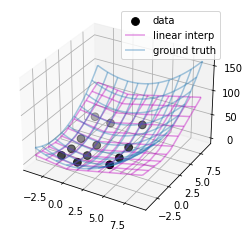

In [ ]:
x, y = np.array([-2, 0, 4]), np.array([-2, 0, 2, 5])
def ff(x, y):
    return x**2 + y**2

xg, yg = np.meshgrid(x, y, indexing='ij')
data = ff(xg, yg)
interp = RegularGridInterpolator((x, y), data, bounds_error=False, fill_value=None)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xg.ravel(), yg.ravel(), data.ravel(), s=60, c='k', label='data')

xx = np.linspace(-4, 9, 31)
yy = np.linspace(-4, 9, 31)
X, Y = np.meshgrid(xx, yy, indexing='ij')

# interpolator
ax.plot_wireframe(X, Y, interp((X, Y)), rstride=3, cstride=3, alpha=0.4, color='m', label='linear interp')

# ground truth
ax.plot_wireframe(X, Y, ff(X, Y), rstride=3, cstride=3, alpha=0.4, label='ground truth')
plt.legend()
plt.show()

In [ ]:
lista = [[1,2,3,4,5,6,7,8], [1,2,3,4,5,6,7,8]]
print(lista[0][:0])

[]
